In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import tifffile

In [2]:
import mm3_adapted_cell_segmentation as mm3seg
import mm3_adapted_cell_tracking as mm3track

In [35]:
path_to_stack = '/Users/noravivancogonzalez/Desktop/20241114/hyperstacked/drift_corrected/rotated/mm_channels/subtracted//subtracted_FOV_001_region_1164_c_0.tif'
output_path = '/Users/noravivancogonzalez/Desktop/20241114/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/outputs'

In [ ]:
mm3seg.segment_chnl_stack(path_to_stack,
						   output_path,
						   OTSU_threshold=1.5,
						   first_opening=5,
						   distance_threshold=3,
						   second_opening_size=1,
						   min_object_size=5) # all these parameters depend on pixels and whether there is binning

In [3]:
fov_id = '001'
peak_id = '1164' # '2227' #'1314' 
path_to_phase_stack = f'/Users/noravivancogonzalez/Desktop/20241114/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_0.tif'
labeled_stack = f'/Users/noravivancogonzalez/Desktop/20241114/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/mm3_segmented_subtracted_FOV_{fov_id}_region_{peak_id}_c_0.tif'
path_to_fluor_stack = f'/Users/noravivancogonzalez/Desktop/20241114/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_1.tif'

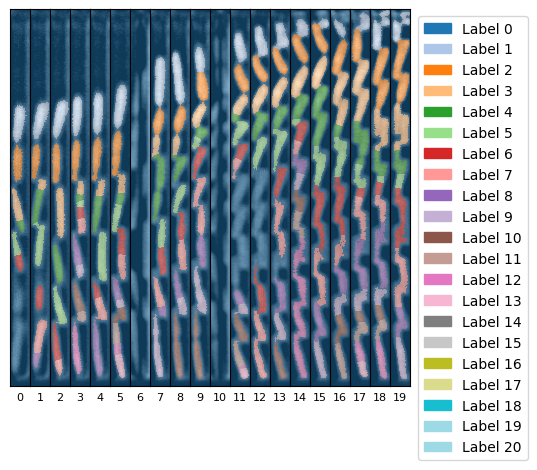

In [5]:
mm3seg.display_segmentation(path_to_phase_stack, mask_path = labeled_stack, cells_df=None, start=0, end=20, alpha=0.5)

In [6]:
cells_dict = mm3track.make_lineage_chnl_stack(path_to_stack = path_to_phase_stack, labeled_stack = labeled_stack, fov_id = int(fov_id), peak_id = int(peak_id), time_btwn_frames =5, pxl2um = 1)

In [7]:
mm3track.find_cell_intensities(path_to_fluor_stack, labeled_stack, cells_dict, midline=False)

In [8]:
cells_pd = mm3track.cells2df(cells_dict, num_time_frames = 5)

In [9]:
cells_pd.head(3)

,cell_id,fov,peak,birth_label,parent,daughters,birth_time_index,time_index,labels,areas_(pxls^2),lengths_(pxls),widths_(pxls),orientations,centroids,generation time_(min),fl_area_avgs,bb_xLeft,bb_yTop,bb_width,bb_height
0,f01p1164t0000r01,1,1164,1,None,"[f01p1164t0009r02, f01p1164t0009r03]",0,0,1,329.0,37.125,10.546875,1.453125,"(113.1, 8.37)",45.0,11.352584,96,3,134,17
0,f01p1164t0000r01,1,1164,1,None,"[f01p1164t0009r02, f01p1164t0009r03]",0,1,1,355.0,38.28125,9.976562,1.296875,"(109.5, 10.055)",45.0,12.614085,93,3,130,19
0,f01p1164t0000r01,1,1164,1,None,"[f01p1164t0009r02, f01p1164t0009r03]",0,2,1,353.0,38.84375,9.820312,1.328125,"(108.0, 9.57)",45.0,10.858357,91,3,130,19


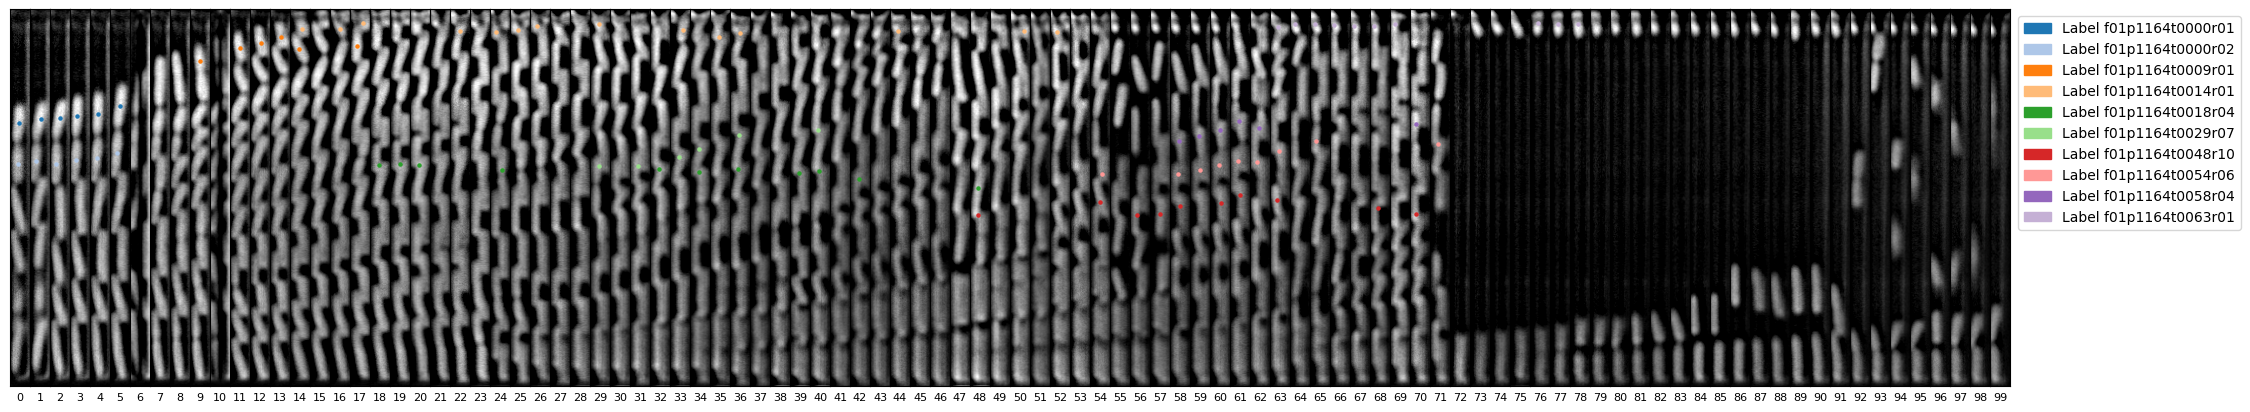

In [11]:
mm3seg.display_segmentation(path_to_phase_stack, mask_path = None, alpha = 0.5, cells_df = cells_pd, start=0, end=100)

In [20]:
def cell_color_dict(cells_df):
    color_dict = {}
    unique_cell_ids = cells_df['cell_id'].unique()
    total_number_labels = len(unique_cell_ids)
    number_of_colors_needed = max(20, total_number_labels)
    # Get a colormap with  distinct colors, for potential cell labels
    cmap = plt.cm.get_cmap('tab20', number_of_colors_needed)
    # Create a dictionary mapping integers to hex color codes
    for color_i, cell_id in enumerate(unique_cell_ids):
        color = cmap(color_i)[:3]  # Extract RGB values
        color_dict[cell_id] = color
    return color_dict

In [21]:
color_dict = cell_color_dict(cells_pd)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_32184/419849173.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', number_of_colors_needed)


Text(0.5, 28.999999999999986, 'Time frames')

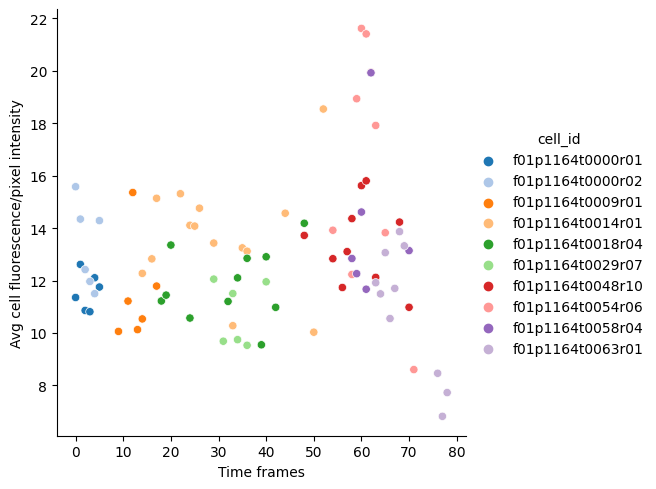

In [29]:
sns.relplot(data=cells_pd, x= 'time_index', y= 'fl_area_avgs', hue= 'cell_id', palette = color_dict)

sns.despine()

plt.ylabel('Avg cell fluorescence/pixel intensity')
plt.xlabel('Time frames')

Text(0.5, 28.999999999999986, 'Time frames')

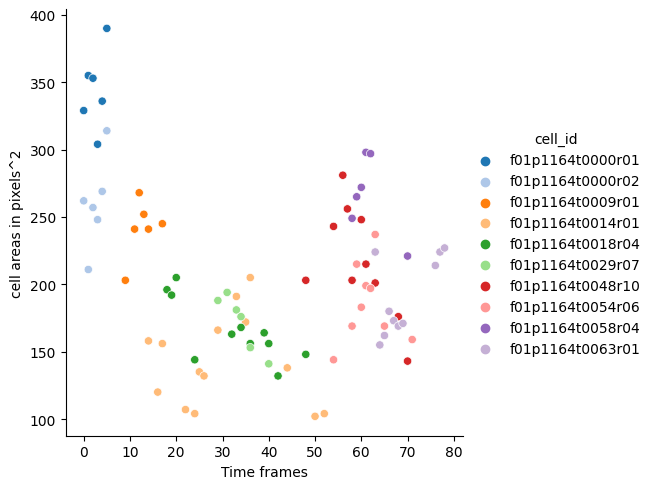

In [31]:
sns.relplot(data=cells_pd, x= 'time_index', y= 'areas_(pxls^2)', hue= 'cell_id', palette = color_dict)

sns.despine()

plt.ylabel('cell areas in pixels^2')
plt.xlabel('Time frames')

In [32]:
cells_pd['cell_id'].unique()

array(['f01p1164t0000r01', 'f01p1164t0000r02', 'f01p1164t0009r01',
       'f01p1164t0014r01', 'f01p1164t0018r04', 'f01p1164t0029r07',
       'f01p1164t0048r10', 'f01p1164t0054r06', 'f01p1164t0058r04',
       'f01p1164t0063r01'], dtype=object)

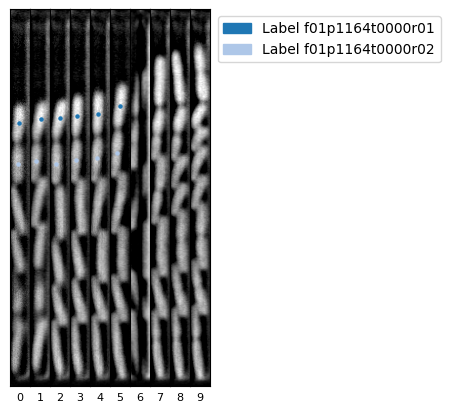

In [33]:
cell_df = cells_pd[cells_pd['cell_id'].isin(['f01p1164t0000r01', 'f01p1164t0000r02'])] 

mm3seg.display_segmentation(path_to_phase_stack, mask_path = None, alpha = 0.5, cells_df = cell_df, start=0, end=10)

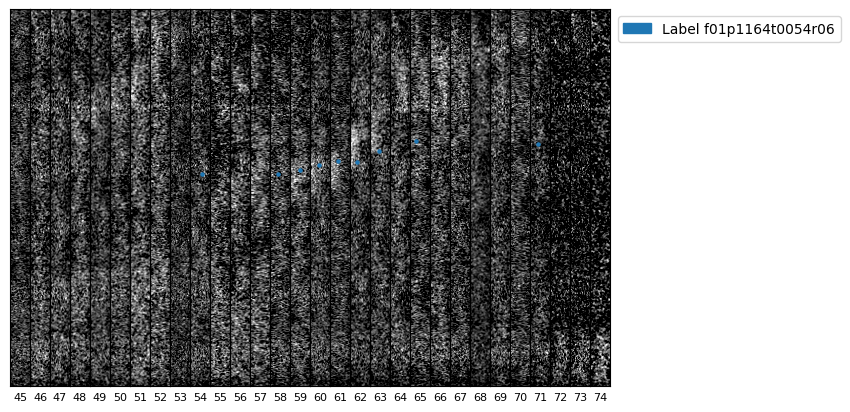

In [34]:
cell_df = cells_pd[cells_pd['cell_id'].isin(['f01p1164t0054r06'])] 

mm3seg.display_segmentation(path_to_fluor_stack, mask_path = None, alpha = 0.5, cells_df = cell_df, start=45, end=75)

In [76]:
path_to_image = '/Users/noravivancogonzalez/Desktop/20241114/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/FOV_001/region_1164/subtracted_FOV_001_region_1164_time_0061_c_0.tif'
image = tifffile.imread(path_to_image)

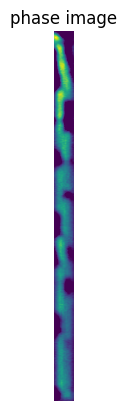

In [120]:
plt.figure()
plt.imshow(image)
plt.title('phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

In [80]:
from skimage.filters import threshold_otsu

In [132]:
OTSU_threshold=1.5
first_opening = 3
distance_threshold=3
second_opening_size=1
min_object_size=5
thresh = threshold_otsu(image)  # finds optimal OTSU threshhold value
threshholded = image > OTSU_threshold * thresh  # will create binary image

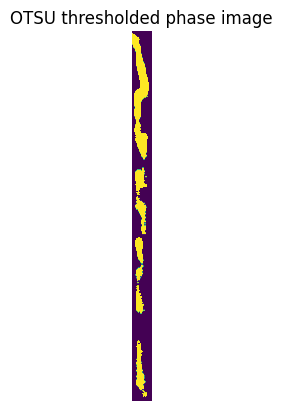

In [133]:
plt.figure()
plt.imshow(threshholded)
plt.title('OTSU thresholded phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

In [140]:
# Opening = erosion then dialation.
# opening smooths images, breaks isthmuses, and eliminates protrusions.
# "opens" dark gaps between bright features.
# Create a diagonal line-shaped footprint
diagonal_footprint = np.zeros((5, 5))
np.fill_diagonal(diagonal_footprint, 1)

morph = morphology.binary_opening(threshholded, diagonal_footprint)

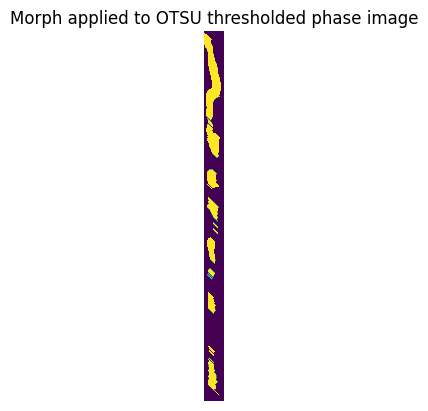

In [141]:
plt.figure()
plt.imshow(morph)
plt.title('Morph applied to OTSU thresholded phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

In [152]:
distance_threshold = 3
distance = ndi.distance_transform_edt(morph)
# threshold distance image
distance_thresh = np.zeros_like(distance)
distance_thresh[distance < distance_threshold] = 0
distance_thresh[distance >= distance_threshold] = 1

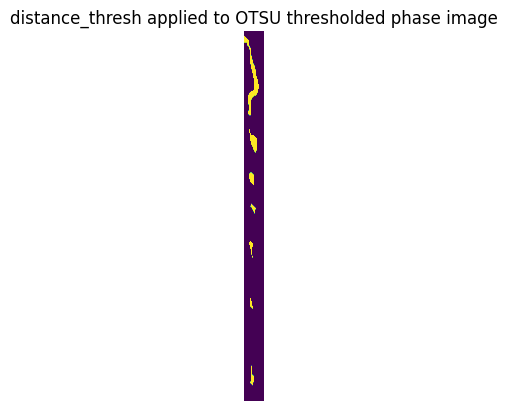

In [153]:
plt.figure()
plt.imshow(distance_thresh)
plt.title('distance_thresh applied to OTSU thresholded phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

In [154]:
distance_opened = morphology.binary_opening(
        distance_thresh, morphology.disk(1)
)

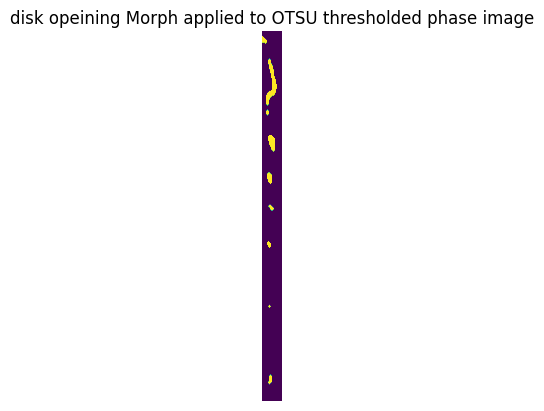

In [155]:
plt.figure()
plt.imshow(distance_opened)
plt.title('disk opeining Morph applied to OTSU thresholded phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

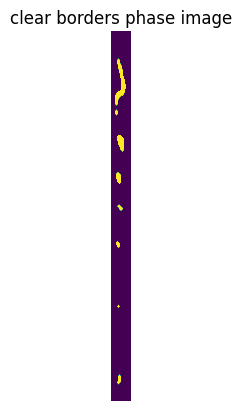

In [157]:
# remove artifacts connected to image border
cleared = segmentation.clear_border(distance_opened)
plt.figure()
plt.imshow(cleared)
plt.title('clear borders phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

In [171]:
labeled, label_num = morphology.label(cleared, connectivity=1, return_num=True)
if label_num > 1:
    labeled = morphology.remove_small_objects(labeled, min_size=5)

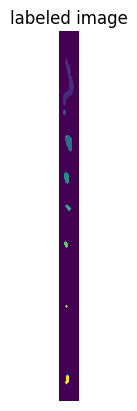

In [172]:
plt.figure()
plt.imshow(labeled)
plt.title('labeled image')
plt.axis('off')  # Hide axis labels
plt.draw()

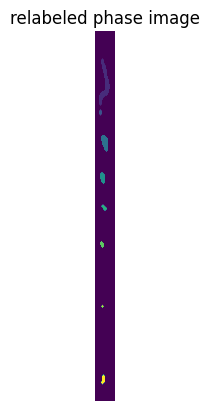

In [173]:
# relabel now that small objects and labels on edges have been cleared
markers = morphology.label(labeled, connectivity=2)
plt.figure()
plt.imshow(markers)
plt.title('relabeled phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

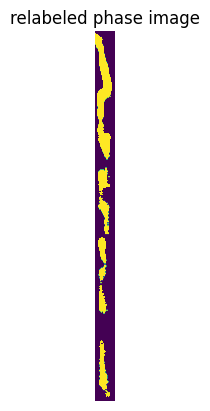

In [174]:
# the binary image for the watershed, which uses the unmodified OTSU threshold
threshholded_watershed = threshholded
plt.figure()
plt.imshow(threshholded_watershed)
plt.title('relabeled phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

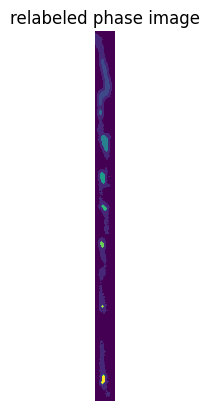

In [175]:
# set anything outside of OTSU threshold to -1 so it will not be labeled
markers[threshholded_watershed == 0] = -1
# here is the main algorithm
plt.figure()
plt.imshow(markers)
plt.title('relabeled phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


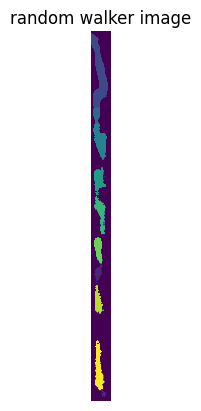

In [176]:
labeled_image = segmentation.random_walker(-1 * image, markers)
plt.figure()
plt.imshow(labeled_image)
plt.title('random walker image')
plt.axis('off')  # Hide axis labels
plt.draw()

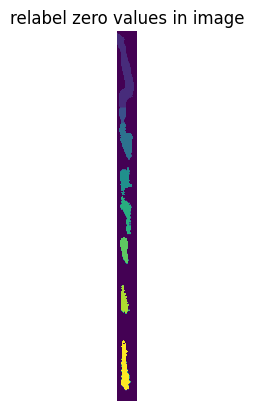

In [177]:
# put negative values back to zero for proper image
labeled_image[labeled_image == -1] = 0
plt.figure()
plt.imshow(labeled_image)
plt.title('relabel zero values in image')
plt.axis('off')  # Hide axis labels
plt.draw()